In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata as ad
from scipy.sparse import issparse
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def infercnv_heatmap(expression_df, obs, group_by, show_var_group = True, figsize = (16, 10), xlabel='', ylabel='', center=1):
    """
    
    """
    expression_df = expression_df[~expression_df.index.str.startswith('MT-')]
    tmp_adata = ad.AnnData(X=expression_df.values.T.astype(np.float32), obs=obs.loc[expression_df.columns])
    
    gtf = pd.read_csv('/home/dchafamo/spatial_dc/final/results/infercnv/hg38_gencode_v27.csv')
    gtf.columns = ["gene", "chromosome", "start", "end"]
    gtf.index = gtf.gene
    gtf = gtf[["chromosome", "start", "end"]]
    gtf = gtf[gtf.index.isin(expression_df.index)]
    expression_df = expression_df.loc[gtf.index]
    
    chr_pos_dict = {c : np.where(gtf.chromosome.values == c)[0][0] for c in gtf.chromosome.unique()}
    chr_pos_dict = dict(sorted(chr_pos_dict.items(), key=lambda x: x[1]))
    chr_pos = list(chr_pos_dict.values())
    var_group_positions = list(zip(chr_pos, chr_pos[1:] + [tmp_adata.shape[1]]))
    
    norm = mcolors.TwoSlopeNorm(center, vmin=np.nanmin(tmp_adata.X), vmax=np.nanmax(tmp_adata.X))

    # fig = plt.figure(figsize=(15,10))
    return_ax_dic = sc.pl.heatmap(
        tmp_adata,
        var_names=tmp_adata.var.index.values,
        groupby=group_by,
        cmap='bwr',
        show_gene_labels=False,
        var_group_positions=var_group_positions if show_var_group else None,
        var_group_labels=list(chr_pos_dict.keys()),
        norm=norm,
        show=False,
        figsize = figsize
    )
    return_ax_dic["heatmap_ax"].vlines(chr_pos[1:], lw=0.6, ymin=0, ymax=tmp_adata.shape[0], colors='k')
    return_ax_dic['heatmap_ax'].set_xlabel(xlabel)
    return_ax_dic['groupby_ax'].set_ylabel(ylabel) 
    return return_ax_dic

***
***
        Smoothed Expression Plots
***
***

In [4]:
gtf = pd.read_csv('/home/dchafamo/spatial_dc/final/results/infercnv/hg38_gencode_v27.csv')
gtf.columns = ["gene", "chromosome", "start", "end"]
gtf.index = gtf.gene
gtf = gtf[["chromosome", "start", "end"]]

In [5]:
adata = sc.read_h5ad("/home/dchafamo/spatial_dc/final/data/combined_dataset_final_v2.h5ad")

dmap = {v:f'Donor {k}' for k,v in enumerate(adata.obs.donor.unique())}
adata.obs['donor_id'] = adata.obs.donor.map(dmap)

In [6]:
adata = adata[adata.obs.condition == 'HL'].copy()

In [7]:
obs = [pd.read_csv(f'/home/dchafamo/spatial_dc/final/results/infercnv/output_dir_infercnv_{donor_id}/infercnv.observations.txt', sep=' ')
 for donor_id in adata.obs.donor.unique()]
obs_df = pd.concat(obs, join='inner', axis=1)

In [8]:
ref = [pd.read_csv(f'/home/dchafamo/spatial_dc/final/results/infercnv/output_dir_infercnv_{donor_id}/infercnv.references.txt', sep=' ')
 for donor_id in adata.obs.donor.unique()]
ref_df = pd.concat(ref, join='inner', axis=1)

In [9]:
ref_df.shape

(4646, 226282)

In [10]:
idx, col = list(adata.obs.index), list(ref_df.columns)
ref_df = ref_df.loc[:,np.in1d(col, idx)]

In [11]:
obs_df = obs_df.loc[obs_df.index.intersection(gtf.index), :]
ref_df = ref_df.loc[ref_df.index.intersection(gtf.index), :]

In [12]:
group_by = 'donor_id'
obs = pd.DataFrame(adata.obs.loc[:,group_by])

In [13]:
ebpos_df = obs_df.loc[:,adata.obs.loc[obs_df.columns].ebv_status == 'positive']
ebneg_df = obs_df.loc[:,adata.obs.loc[obs_df.columns].ebv_status == 'negative']

In [14]:
ebpos_df = ebpos_df.loc[:,obs.loc[ebpos_df.columns].groupby('donor_id', as_index=False, group_keys=False)\
                        .apply(lambda x: x.sample(min(500, len(x)))).index]
ebneg_df = ebneg_df.loc[:,obs.loc[ebneg_df.columns].groupby('donor_id', as_index=False, group_keys=False).\
                        apply(lambda x: x.sample(min(250, len(x)))).index]

... storing 'donor_id' as categorical
... storing 'donor_id' as categorical
... storing 'donor_id' as categorical


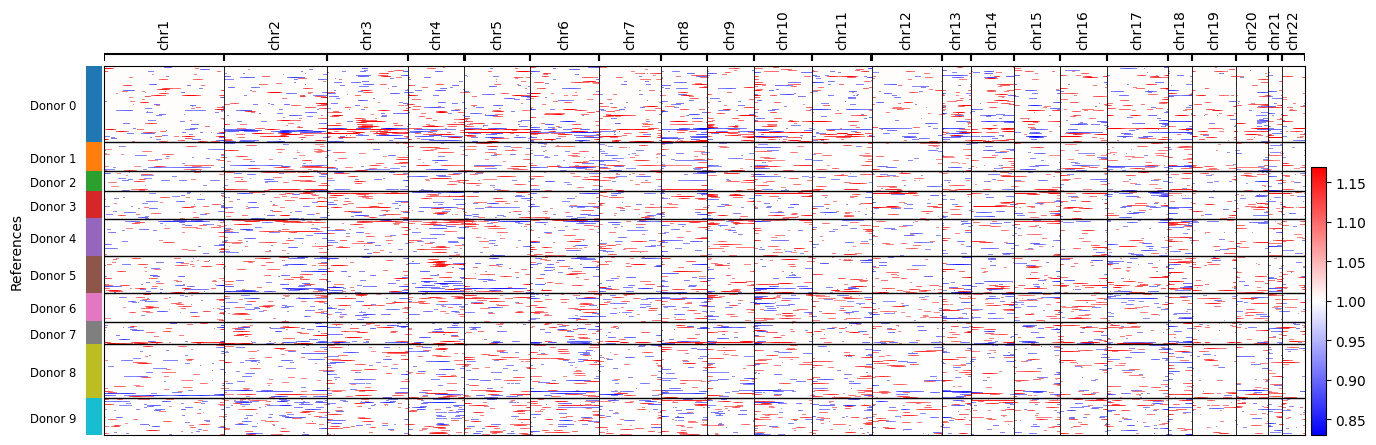

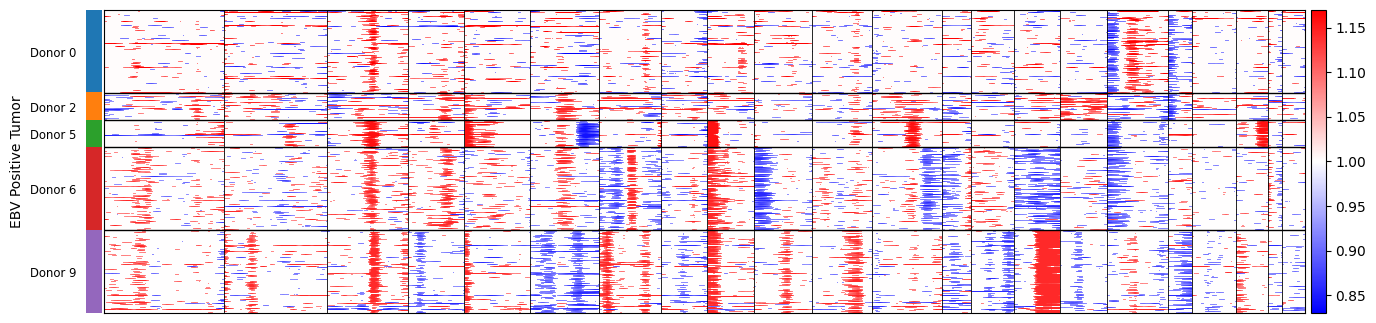

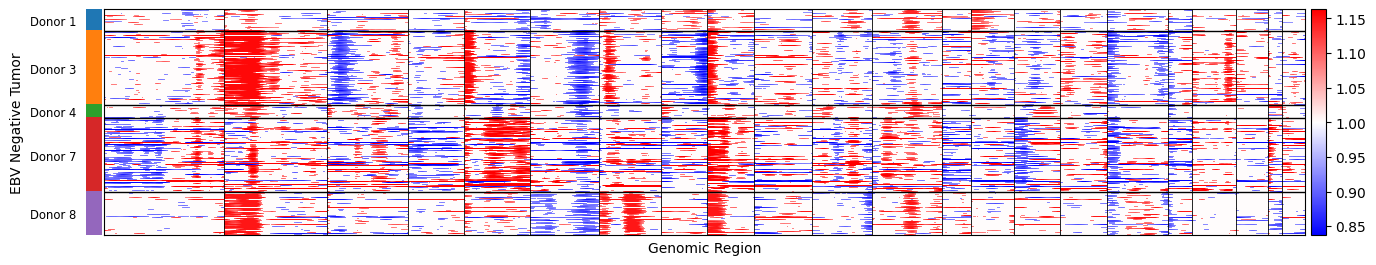

In [21]:
return_ax_dic_1 = infercnv_heatmap(ref_df, obs, group_by, figsize = (16, 5), ylabel='References')
return_ax_dic_2 = infercnv_heatmap(ebpos_df, obs, group_by, figsize = (16, 4), show_var_group = False, ylabel='EBV Positive Tumor')
return_ax_dic_3 = infercnv_heatmap(ebneg_df, obs, group_by, figsize = (16, 3), show_var_group = False, ylabel='EBV Negative Tumor', 
                                 xlabel='Genomic Region')

In [23]:
return_ax_dic_1['groupby_ax'].get_figure().savefig("CNVS_REF.pdf", dpi=300, bbox_inches="tight")
return_ax_dic_2['groupby_ax'].get_figure().savefig("CNVS_EBV_POS.pdf", dpi=300, bbox_inches="tight")
return_ax_dic_3['groupby_ax'].get_figure().savefig("CNVS_EBV_NEG.pdf", dpi=300, bbox_inches="tight")

In [19]:
plt.show()return_ax_dic

In [16]:
plt.savefig("test.pdf", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>